### SUPERNOVA
### Firecrown-SACC Demo Notebook
#### Ayan Mitra
##### Aug, 2022

#### In this notebook we demonstrate how any given SN input Hubble Diagram and an associated covariance matrix can be converted into a `SACC` summary statistics file.

In [2]:
!pwd

/global/u1/a/ayanmitr/soft/firecrown/examples/srd_sn


In [1]:
#from cosmosis.postprocessing import plots
#from cosmosis.postprocessing import lazy_pylab as pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getdist
from matplotlib.colors import LogNorm,Normalize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import sacc
from sacc import Sacc, standard_types
import os
import glob
import tarfile
import urllib.request
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import matplotlib.pyplot as plt
#plt.plot();

# Code to generate the SACC file for a given SN data

In [4]:
sources = ['supernova']
properties = ['distance']

# The statistc                                                                                                                               
statistic = 'mu'

# There is no futher specified needed here - everything is scalar.                                                                           
subtype = None
sndata_type = sacc.build_data_type_name(sources, properties, statistic, subtype)

type_details = sacc.parse_data_type_name(sndata_type)
print('type_details.sources, type_details.properties, type_details.statistic, type_details.subtype')
print(type_details.sources, type_details.properties, type_details.statistic, type_details.subtype)

type_details.sources, type_details.properties, type_details.statistic, type_details.subtype
['supernova'] ['distance'] mu None


#### Below we will convert SN data produced from
##### SNANA simulations, using PLAsTiCC input

In [5]:
S = Sacc()
y1dat=np.loadtxt('sndata/data.txt', unpack=True)    # Hubble Diagram Input
y1cov = np.loadtxt('sndata/sys_0.txt', unpack=True) # Covariance Matrix Input. SNANA, UNBINNED, SPECZ, FOLDER 0
zhel = y1dat[2] # redshift                                                                                                                   
zcmb = y1dat[1] # redshift                                                                                                                   
mb = y1dat[4]
dmb = y1dat[5]
zmu = np.vstack((zcmb,mb))
size=int(y1cov[0]) # reading the size of the matrix from the first entry                                                                     
cov = np.zeros((size,size))
count=1 # since the cov mat starts with the number of lines

In [6]:
S.add_tracer('misc', 'sn_ddf_sample')

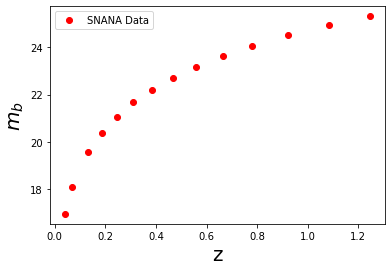

In [7]:
# Plotting the data to check consistency
plt.plot(zhel,mb,'o',c='r',label='SNANA Data')
plt.xlabel('z',fontsize=20)
plt.ylabel('$m_b$',fontsize=20)
plt.legend()

In [8]:
for i in range(size):
    # Add the appropriate tracer                                                                                                             
    S.add_data_point(sndata_type, ('sn_ddf_sample',),  mb[i], z=zcmb[i]) # can add absmag=-19.9 or other tags                                
    for j in range(size):
        cov[i,j]=y1cov[count]
        count+=1
    for i in range(size):
        cov[i,i]+=(dmb[i])**2

In [9]:
S.add_covariance(cov)
S.metadata['nbin_distmod'] = size
S.metadata['simulation'] = 'SNANA'
S.metadata['covmat']  = 'sys_SNANA'
S.metadata['creation'] = datetime.datetime.now().isoformat()
S.metadata['info'] = 'SN SNANA data sets-UNBINNED, SPECZ, FOLDER 0'

In [10]:
S.save_fits('sndata/SNANA-srd-y1-converted.sacc', overwrite=True)

#### -------
#### Sacc Generation : Complete
##### To run the sampling, we need to add the correct path for the likelihood generation. This is done in the program 'sn_srd.py' where we specify the path to the Sacc data file. Then compile 'python setup.py install' from the root directory. Then run 'cosmosis sn_srd.ini' or we can submit it as a job (see the submit_job.sh example file). The output is analysed below using getDist.